# Hydrogen storage tank

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import cantera as ct

from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity

from scipy.integrate import solve_ivp

In [3]:
temp_ambient = Q_(25, 'degC')

# supply of hydrogen has constant conditions
supply = ct.Hydrogen()
supply.TP = (
    temp_ambient.to('K').magnitude,
    Q_(300, 'bar').to('Pa').magnitude
    )

# tank properties
tank = {'number': 3, 
        'height': Q_(65, 'cm'),
        'diameter': Q_(28, 'cm')
        }

volume_tank = np.pi * tank['height'] * tank['diameter']**2 / 4.0

# initial state
temp_initial = temp_ambient
pres_initial = Q_(60, 'bar')
hydrogen = ct.Hydrogen()
hydrogen.TP = temp_initial.to('K').magnitude, pres_initial.to('Pa').magnitude

mass_initial = (tank['number'] * volume_tank) / Q_(hydrogen.v, 'm^3/kg')
int_energy_initial = mass_initial * Q_(hydrogen.u, 'J/kg')

Next, we need to define a function that evaluates the time derivatives for this system:

In [5]:
def tank_rates(t, y, supply, tank, temp_ambient):
    '''Evaluates time derivatives for mass and internal energy (dm/dt and dU/dt)
    '''
    mass = Q_(y[0], 'kg')
    internal_energy = Q_(y[1], 'J')
    
    surface_area_tank = tank['number'] * (
        2 * np.pi*tank['diameter']**2 / 4.0 + 
        np.pi*tank['diameter']*tank['height']
        )
    volume_tank = np.pi * tank['height'] * tank['diameter']**2 / 4.0
    
    # specify state based on mass and internal_energy
    specific_volume = (tank['number'] * volume_tank) / mass
    specific_internal_energy = internal_energy / mass
    f = ct.Hydrogen()
    f.UV = (
        specific_internal_energy.to('J/kg').magnitude, 
        specific_volume.to('m^3/kg').magnitude
        )
    
    C_valve = Q_(2.68e-6, 'kg/(s*Pa**0.5)')
    mdot = C_valve * np.sqrt(Q_(supply.P, 'Pa') - Q_(f.P, 'Pa'))
    dmdt = mdot
    
    h_conv = Q_(40, 'W/(m**2 K)')
    Qdot = h_conv * surface_area_tank * (temp_ambient - Q_(f.T, 'K'))
    dUdt = (mdot * Q_(supply.h, 'J/kg')) + Qdot
    
    return [dmdt.to('kg/s').magnitude, dUdt.to('J/s').magnitude]

**Choice of method:** Here we use the `'BDF'` for the `method` argument, which tells the `solve_ivp()` function to use an implicit integration method based on backward differentiation formula. Other methods [are available](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) and may be more efficient for some problems, but this is fairly accurate and can handle stiffness in the ODE system.

In [14]:
# now integrate over 3 minutes, 
# using backward differentiation formula (BDF) method
sol = solve_ivp(
    tank_rates, [0, 60*3], 
    [mass_initial.to('kg').magnitude, int_energy_initial.to('J').magnitude],
    args=(supply, tank, temp_ambient,),
    method='BDF'
    )

The integration was successful (it did not report an error), so now plot temperature and pressure of the tank as a function of time.

We have the system mass and internal energy as a function of time, and we'll need to use those to specify the system at each state to obtain its properties as a function of time.

<IPython.core.display.Javascript object>


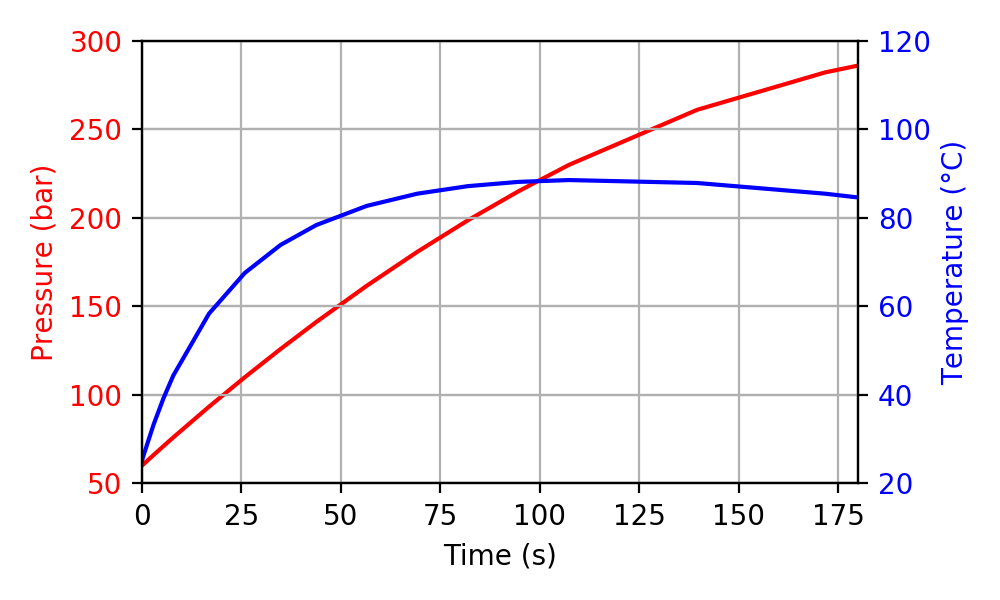

In [9]:
pressures = np.zeros(len(sol.y[0]))
temperatures = np.zeros(len(sol.y[0]))

for idx in range(len(sol.y[0])):
    mass = Q_(sol.y[0][idx], 'kg')
    internal_energy = Q_(sol.y[1][idx], 'J')
    
    volume_tank = np.pi * tank['height'] * tank['diameter']**2 / 4.0
    
    specific_volume = (tank['number'] * volume_tank) / mass
    specific_internal_energy = internal_energy / mass
    f = ct.Hydrogen()
    f.UV = (
        specific_internal_energy.to('J/kg').magnitude, 
        specific_volume.to('m^3/kg').magnitude
        )
    
    pressures[idx] = f.P
    temperatures[idx] = f.T
    
pressures *= ureg.Pa
temperatures *= ureg.K

fig, ax1 = plt.subplots(figsize=(5, 3))

color = 'red'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Pressure (bar)', color=color)
ax1.plot(sol.t, pressures.to('bar').magnitude, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axis([0, 180, 50, 300])
ax1.grid(True)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
# we already handled the x-label with ax1
ax2.set_ylabel('Temperature (°C)', color=color)
ax2.plot(sol.t, temperatures.to('degC').magnitude, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.axis([0, 180, 20, 120])
ax2.grid(True)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Now plot the mass of fuel added as a function of time:

<IPython.core.display.Javascript object>


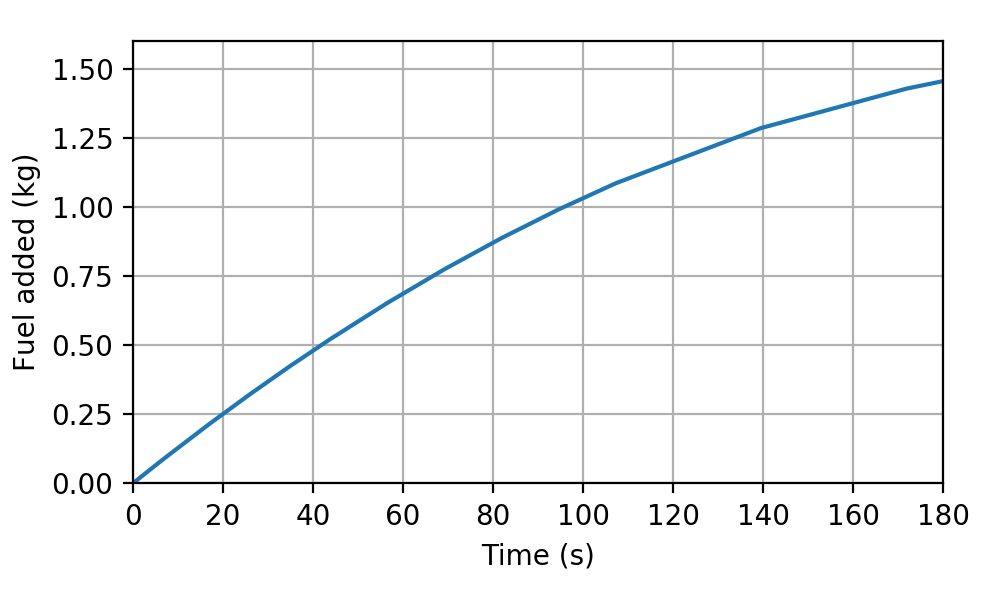

In [13]:
mass_added = sol.y[0] - mass_initial.to('kg').magnitude
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(sol.t, mass_added)
plt.xlabel('Time (s)')
plt.axis([0, 180, 0, 1.6])
plt.ylabel('Fuel added (kg)')
plt.grid(True)
fig.tight_layout()
plt.show()